In [3]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

from __future__ import division
from __future__ import print_function

import sys,time,datetime,copy,subprocess,itertools,pickle,warnings,json,gc,numbers

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [8]:
import Hawkes as hk

para = {"mu":0.1, "alpha":0.5, "beta":10.0}
itv = [0,10000]

h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = h1.simulate(itv)
print(len(T))

h2 = hk.estimator().set_kernel('exp').set_baseline('const')
h2.fit(T,itv)
print(h2.para)

print()
%timeit -n1 -r1 h2.fit(T,itv)

1967
mu     0     0.100105
alpha  0     0.491075
beta   0    10.298716
dtype: float64

6.71 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
import Hawkes as hk

para = {"mu":0.1, "alpha":[0.25,0.25], "beta":[1.0,20.0]}
itv = [0,10000]

h1 = hk.simulator().set_kernel('exp',num_exp=2).set_baseline('const').set_parameter(para)
T = h1.simulate(itv)
print(len(T))

h2 = hk.estimator().set_kernel('exp',num_exp=2).set_baseline('const')
h2.fit(T,itv)
print(h2.para)

print()
%timeit -n1 -r1 h2.fit(T,itv)

2111
mu     0     0.106019
alpha  0     0.261144
       1     0.236727
beta   0     1.156131
       1    21.990631
dtype: float64

11.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
import Hawkes as hk

para = {"mu":0.1, "k":0.5,"p":2.0,"c":1.0}
itv = [0,10000]

h1 = hk.simulator().set_kernel('pow').set_baseline('const').set_parameter(para)
T = h1.simulate(itv)
print(len(T))

h2 = hk.estimator().set_kernel('pow').set_baseline('const')
h2.fit(T,itv)
print(h2.para)

print()
%timeit -n1 -r1 h2.fit(T,itv)

1842
mu  0    0.088222
k   0    0.187915
p   0    1.574545
c   0    0.438243
dtype: float64

1.21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1239
mu     0     8.830406
       1    19.798958
       2    16.921515
       3     2.581610
       4     1.847218
       5     9.146220
alpha  0     0.190743
beta   0     5.848329
dtype: float64
mu     0    1.179539
       1    0.435673
       2    6.212708
       3   -1.525418
       4    0.887298
       5    9.369292
alpha  0    0.256450
beta   0    4.596452
dtype: float64


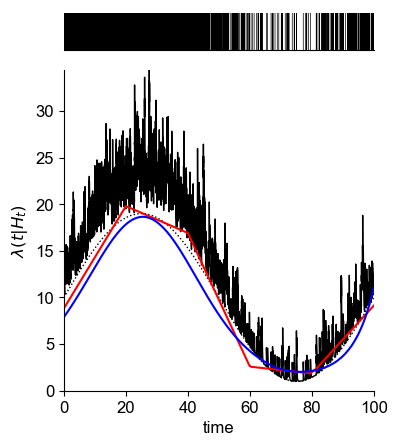

In [13]:
import Hawkes as hk

para = {"alpha":0.2,"beta":10.0}
mu_t = lambda x: 10.0 + 9.0*np.sin(2*np.pi*x/100)
itv = [0,100]
h1 = hk.simulator().set_kernel("exp").set_baseline('custom',l_custom=mu_t).set_parameter(para)
T = h1.simulate(itv)
print(len(T))

# piecewise lienar model
h2 = hk.estimator().set_kernel("exp").set_baseline('plinear',num_basis=6)
h2.fit(T,itv)
print(h2.para)

# log-linear model
h3 = hk.estimator().set_kernel("exp").set_baseline('loglinear',num_basis=6)
h3.fit(T,itv)
print(h3.para)

h1.plot_l()
plt.plot(T,h2.baseline.l(T),"r-")
plt.plot(T,h3.baseline.l(T),"b-")
pass

In [6]:
####################################
## multi seq
####################################

import Hawkes as hk

para = {"mu":0.1, "alpha":0.5, "beta":10.0}
itv = [0,10000]

h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)

T_list = [ h1.simulate(itv) for i in range(10) ]
itv_list = [itv]*10

print([ len(T_list[i]) for i in range(10) ])

h2 = hk.estimator_MultiSeq().set_kernel('exp').set_baseline('const_MultiSeq')
h2.fit(T_list,itv_list,10)

print(h2.para)

[1830, 2145, 2031, 2087, 1927, 1976, 2043, 1842, 2091, 2067]
mu     0    0.099993
alpha  0    0.501009
beta   0    9.826696
dtype: float64


9878
0.18398536685521988 -4756.658978522176
0.18398536685521988 -4756.658978522176


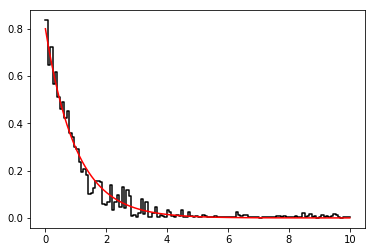

In [21]:
########################## non-parametric model
import Hawkes as hk

para = {"mu":0.2, "alpha":0.8, "beta":1.0}
itv = [0,10000]

h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = h1.simulate(itv)
print(len(T))

support = 10.0
num_bin = 128

###
h2 = hk.estimator_np(support=support,num_bin=num_bin) 
h2.fit(T,itv)
print(h2.para['mu'],h2.L)

h2.plot_kernel()
x = np.linspace(0,support,100)
y = np.exp(-1.0*x)*0.8*1.0
plt.plot(x,y,'r-')

###
h3 = hk.estimator_np_MultiSeq(support=support,num_bin=num_bin).fit([T],[itv],num_seq=1)
print(h3.para['mu'],h3.L)

10655 9218
0.19030414373823373 -9497.441886397748


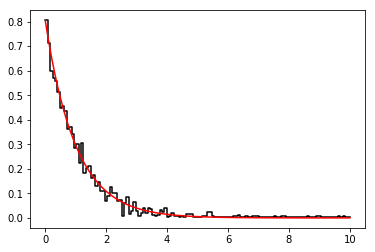

In [23]:
########################## non-parametric model (multi-seq)
import Hawkes as hk

para = {"mu":0.2, "alpha":0.8, "beta":1.0}
h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)

itv1= [0,10000]
itv2= [0,10000]
T1 = h1.simulate(itv1)
T2 = h1.simulate(itv2)
itv = [itv1,itv2]
T = [T1,T2]
print(len(T1),len(T2))

support = 10.0
num_bin = 128
h2 = hk.estimator_np_MultiSeq(support=support,num_bin=num_bin).fit(T,itv,num_seq=2)
print(h2.para['mu'],h2.L)

h2.plot_kernel()
x = np.linspace(0,support,100)
y = np.exp(-1.0*x)*0.8*1.0
plt.plot(x,y,'r-')

pass


In [9]:
########################## non-parametric model (test evaluation)

import Hawkes as hk

T = pd.read_pickle('./NK.pkl')['T']
T = T+1
n = len(T)
n_train = int(n*0.8)
itv = [0,T[n_train-1]+1e-6]

support = 10.0
num_bin = 128
h2 = hk.estimator_np(support=support,num_bin=num_bin)
h2.fit(T,itv)
h2.plot_kernel()
print(h2.L)

h2.set_data({'T':T},[0,T[-1]+1e-6])
h2.L_index()[n_train:].mean()

FileNotFoundError: [Errno 2] No such file or directory: './NK.pkl'